# SD-TSIA210 - Machine Learning
## 	Multi-class Classification: Leaf
### Group 2: 

*   Ferreira Torres, Bernardo
*   Morina, Alessandro
*   Souza Pinto Medeiros, Gabriel
*   Togashi De Miranda, Júlia

## Importing data and libraries

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00288/leaf.zip
!unzip -qq leaf.zip

--2021-04-28 03:41:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/00288/leaf.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81762392 (78M) [application/x-httpd-php]
Saving to: ‘leaf.zip’

leaf.zip            100%[===================>]  77.97M  30.0MB/s    in 2.6s    

2021-04-28 03:41:08 (30.0 MB/s) - ‘leaf.zip’ saved [81762392/81762392]



In [ ]:
import pandas as pd
import tensorflow as tf
import keras
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import graphviz 
import statistics

from imblearn.over_sampling import RandomOverSampler

from sklearn import tree
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import confusion_matrix
from sklearn import decomposition

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout,BatchNormalization
from keras import optimizers

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
cols_names=["Class", "Specimen Number", "Eccentricity", "Aspect Ratio", "Elongation", "Solidity", "Stochastic Convexity", "Isoperimetric Factor",
            "Maximal Indentation Depth", "Lobedness", "Average Intensity", "Average Contrast", "Smoothness", "Third moment", "Uniformity", "Entropy"]
df = pd.read_csv("leaf.csv", header=None, names=cols_names)
df.head(10)

,Class,Specimen Number,Eccentricity,Aspect Ratio,Elongation,Solidity,Stochastic Convexity,Isoperimetric Factor,Maximal Indentation Depth,Lobedness,Average Intensity,Average Contrast,Smoothness,Third moment,Uniformity,Entropy
0,1,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.83592,0.004657,0.003947,0.047790,0.127950,0.016108,0.005232,0.000275,1.17560
1,1,2,0.74173,1.5257,0.36116,0.98152,0.99825,0.79867,0.005242,0.005002,0.024160,0.090476,0.008119,0.002708,0.000075,0.69659
2,1,3,0.76722,1.5725,0.38998,0.97755,1.00000,0.80812,0.007457,0.010121,0.011897,0.057445,0.003289,0.000921,0.000038,0.44348
3,1,4,0.73797,1.4597,0.35376,0.97566,1.00000,0.81697,0.006877,0.008607,0.015950,0.065491,0.004271,0.001154,0.000066,0.58785
4,1,5,0.82301,1.7707,0.44462,0.97698,1.00000,0.75493,0.007428,0.010042,0.007938,0.045339,0.002051,0.000560,0.000024,0.34214
5,1,6,0.72997,1.4892,0.34284,0.98755,1.00000,0.84482,0.004945,0.004451,0.010487,0.058528,0.003414,0.001125,0.000025,0.34068
6,1,7,0.82063,1.7529,0.44458,0.97964,0.99649,0.76770,0.005928,0.006395,0.018375,0.080587,0.006452,0.002271,0.000041,0.53904
7,1,8,0.77982,1.6215,0.39222,0.98512,0.99825,0.80816,0.005099,0.004731,0.024875,0.089686,0.007979,0.002466,0.000147,0.66975
8,1,9,0.83089,1.8199,0.45693,0.98240,1.00000,0.77106,0.006005,0.006564,0.007245,0.040616,0.001647,0.000388,0.000033,0.33696
9,1,10,0.90631,2.3906,0.58336,0.97683,0.99825,0.66419,0.008402,0.012848,0.007010,0.042347,0.001790,0.000459,0.000028,0.28082


## Exploring the data

In [ ]:
print(df.shape)
df.dropna()
print(df.shape)

(340, 16)
(340, 16)


Since the dropna() function did not cause any modification on the shape of the data, we can say that the dataset has no missing data.

We can begin exploring which feature could be relevant to us in predicting the class of the leaves, having in mind that we do not dispose of many samples for each class.

*Specimen Number* feature is completely irrelevant, since it's only an id locally assigned to each sample of each class. <br>
Hence we have to remove it.

In [ ]:
df = df.drop('Specimen Number', 1)
df.head()

,Class,Eccentricity,Aspect Ratio,Elongation,Solidity,Stochastic Convexity,Isoperimetric Factor,Maximal Indentation Depth,Lobedness,Average Intensity,Average Contrast,Smoothness,Third moment,Uniformity,Entropy
0,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.83592,0.004657,0.003947,0.047790,0.127950,0.016108,0.005232,0.000275,1.17560
1,1,0.74173,1.5257,0.36116,0.98152,0.99825,0.79867,0.005242,0.005002,0.024160,0.090476,0.008119,0.002708,0.000075,0.69659
2,1,0.76722,1.5725,0.38998,0.97755,1.00000,0.80812,0.007457,0.010121,0.011897,0.057445,0.003289,0.000921,0.000038,0.44348
3,1,0.73797,1.4597,0.35376,0.97566,1.00000,0.81697,0.006877,0.008607,0.015950,0.065491,0.004271,0.001154,0.000066,0.58785
4,1,0.82301,1.7707,0.44462,0.97698,1.00000,0.75493,0.007428,0.010042,0.007938,0.045339,0.002051,0.000560,0.000024,0.34214


The features from *Eccentricity* to *Lobedness* are all relative to the shape of the leaf, while from *Average Intesity* to *Entropy*, are feature related to a statistical analysis derived from the histograms of greyscales of the original RGB images of the leaves.

All these features seem relevant, since only colors can not efficiently distinguish leaves, and neither shapes alone, like as we can see leaves from class 1 and class 26 in the following image, have too simialr shape but different color intensity.

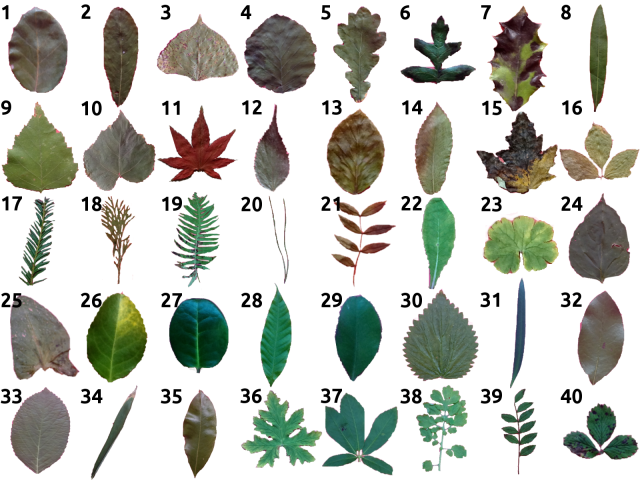

As can be seen in the graph bellow, the classes in this dataset are overall relatively well balanced. On the other hand, as there are a lot of classes, the number of examples for each class is really small (around 12), which is expected to cause difficulties and small variations in the number of occurance, for example from class 11 to class 4/6 turn to be considerable.

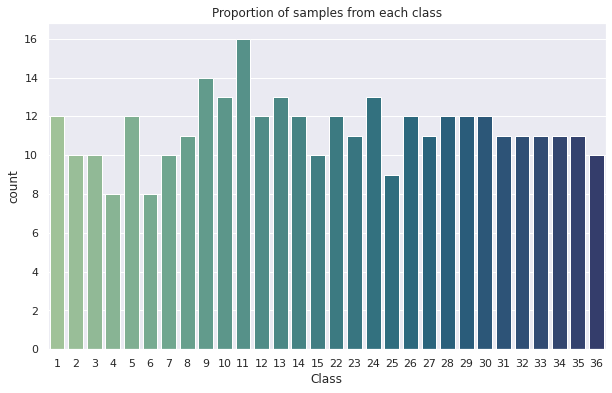

In [ ]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="Class", data=df,palette="crest")
plt.title('Proportion of samples from each class')
plt.show()

But analyzing the dataset, we can see that there more features than samples per each class, so we need to reduce the number of features, considering only the most important ones. <br>
We can apply the PCA reduction (latter), to the feature set, but first let's separate the lables from the dataset and do some other preparation:

In [ ]:
y = df["Class"].to_numpy()
df = df.drop("Class", 1)
X = df.to_numpy()

I also noticed that the labels are not sequential, because in the dataset are not present the complex leaves of the classes from 16 to 21 and from 37 to 40. I will just translate the labels greater than 21, so that we have a contiguous labels sapace.

In [ ]:
for i in range(len(y)):
  if y[i] > 21:
    y[i] -= 6
  y[i] -= 1

As there are few examples of each class, the stratify option will be used in the split. That means that our split will maintain the proportions between classes in the train and test dataset.
 


In [ ]:
# Splitting in train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Since there are some features with several orders of magnitude of difference, it is wise to normalize the data.
# We are normalizing both the train and test data with the train informations,
# since we do not know the distributions, and real testing data statistics is not know during training time.
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

One other implication of a small dataset is that we need to pay attention to outliers. Having one outlier between a thousand of data points might not influence our prediction, but one among ten will.


To check if there any outliers, the distance matrix is plotted below. The value $a_{ij}$ of the matrix corresponds to the distance of the point I to a point j. As can be seen, there is a clear outlier close to our 30th point, as its distance to all points in the dataset is big.
After plotting the matrix, the mean distance of each point to all other datapoints will be calculated and we will define a threshold distance to consider the point an outlier.


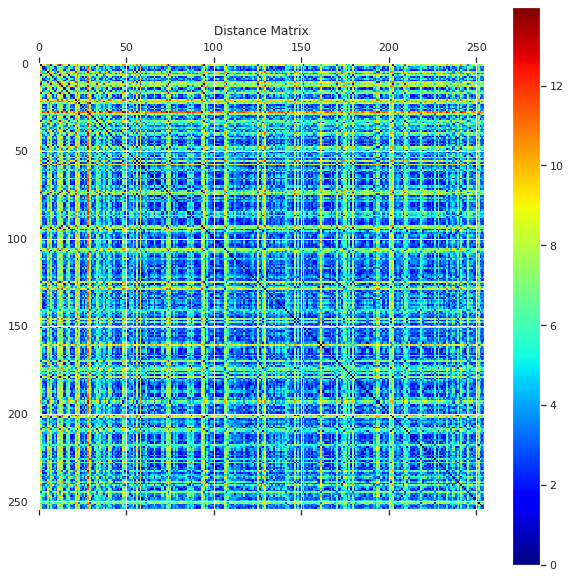

In [ ]:
#ploting distance matrix (distance for each point to every other point)
#Calculating mean distance for each point to all other points 

dist_matriz=euclidean_distances(X_train,X_train)
dist=[]
for i in dist_matriz:
    dist.append(statistics.mean(i))  

plt.figure(figsize=(10, 10))
plt.matshow(dist_matriz,cmap="jet", fignum=1)
cb = plt.colorbar()
plt.title("Distance Matrix")
plt.show()

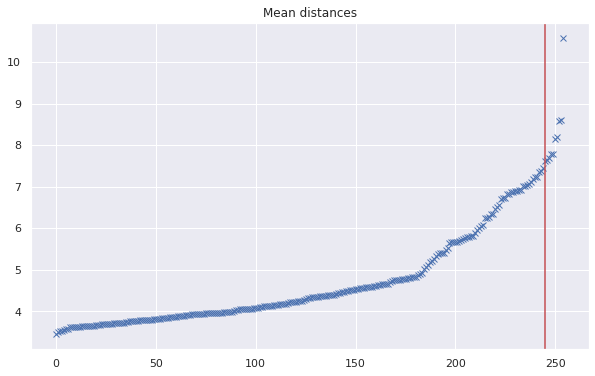

In [ ]:
# Plot of mean distances and threshold to consider outlier  
dist_sort = np.copy(dist)
dist_sort.sort()
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,X_train.shape[0]),dist_sort,'x')
plt.axvline(x=245,c= 'r')
plt.title("Mean distances")
plt.show()

Bellow we get the indices of the points with a distance grater than our threshold. With a 7.5 threshold, 10 points are considered as outliers. This corresponds to less than 4% of our training dataset. Besides, we check the classes that these points belong to, so that we don’t mistakenly remove a class from our dataset (if one class was really different from the others for example).


Taking that into account we remove the outliers.


In [ ]:
# Getting indices of outliers 
dist = np.array(dist)
ind = np.nonzero(dist > 7.5)
print("Values bigger than 7.5 =", dist[dist>7.5])
print("Their indices are ", ind)
print(y_train[ind])

Values bigger than 7.5 = [ 7.78149814  7.63948703  7.7840573   8.60537553 10.58660009  8.14402985
  7.6901486   8.20704105  8.59590432  7.63500702]
Their indices are  (array([  1,  11,  13,  21,  28,  58, 125, 129, 161, 202]),)
[10 18  9 27 24  5 10 24 29 10]


One last procedure is to oversample the least frequent classes from the dataset (for example 4 and 7). For that an oversampling function is used (from imblearn
Library), and it oversamples all classes to the number of examples of the most frequent class. 


In [ ]:
# Removing outliers from dataset
X_train_clean = np.delete(X_train,ind,axis=0)
print(X_train.shape)
print(X_train_clean.shape)
y_train_clean= np.delete(y_train,ind)

# Oversampling less frequent classes
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train_clean, y_train_clean)
print(X_resampled.shape)

(255, 14)
(245, 14)
(330, 14)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Original Dataset 

As already said, the small number of examples for each class will probably pose some problems. Having that in mind, the group chose to apply some methods to the original dataset, as a form of baseline to our results. That way, it can be seen if the methods used to contour the problem were efficient.

### Trees

The first method that the group decide to implement was a Tree. Firstly, because it’s a method in the scope of the course, then because one of its strong advantages is to have a high interpretability. That means that a tree can give us a good idea of which features are the most relevant to our problem.


To find the best hyperparameters (that stops the tree from overfitting), a 5 fold cross validation wil be applied. 


In [ ]:
Tree = DecisionTreeClassifier(random_state=42)
p_grid_tree = {'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15],
              'min_samples_leaf': [2,3,4,5,6,7,8,9,10,11,12,13,14,15] }
grid_tree = GridSearchCV(estimator=Tree, param_grid=p_grid_tree, cv=5,scoring="accuracy")
grid_tree.fit(X_resampled, y_resampled)

best_params= grid_tree.best_params_
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Tree train score :",grid_tree.score(X_resampled, y_resampled))
print("Tree test score :",grid_tree.score(X_test,y_test))
print("Best params: {}".format(grid_tree.best_params_))

Best Validation Score: 0.7333333333333333
Tree train score : 0.9484848484848485
Tree test score : 0.6941176470588235
Best params: {'min_samples_leaf': 2, 'min_samples_split': 2}


As can be seen above, the results for the test set are poor using the tree, specially compared to the train score. To check if the model is overfitting, a graph varying the parameter is plotted below. As can be seen, the model indeed didn’t overfit, but it seems not to successfully describe our data. 

The value of min_samples_leaf that maximizes the training score is :  2
The value of min_samples_leaf that maximizes the test score is :  7


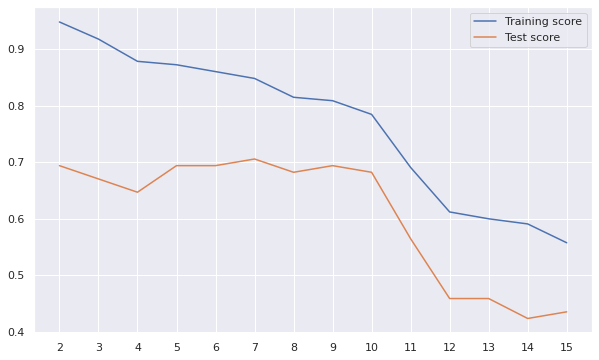

In [ ]:
# min_samples_leaf
TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_leaf=i, random_state=42)
    Tree.fit(X_resampled, y_resampled)
    scoreTrain=Tree.score(X_resampled, y_resampled)
    scoreTest=Tree.score(X_test,y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.figure(figsize=(10, 6))
plt.plot(TTrain,label='Training score');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_leaf that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test score');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_leaf that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend();

Plotting the fitted tree, we can see that some features are clearly important in the classification: that are Solidity; Third moment and aspect Ratio.

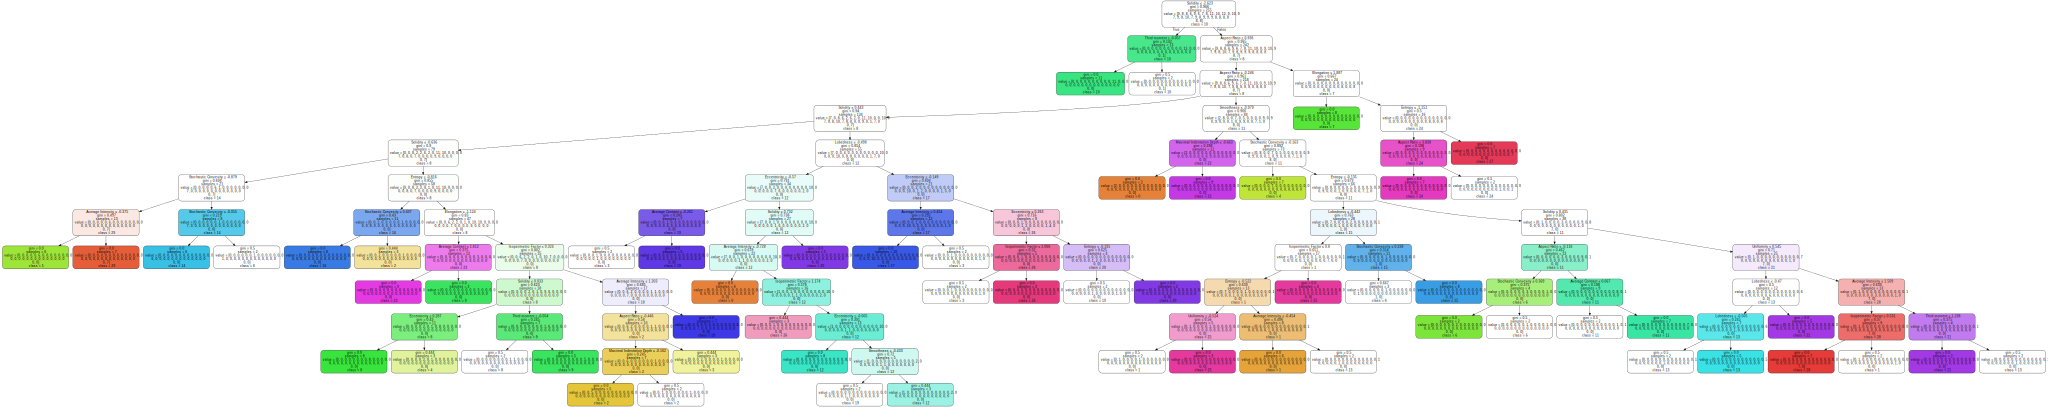

In [ ]:
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)
Tree.fit(X_train,y_train)

dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=df.columns,class_names=np.char.mod('%d', np.unique(y_test)),filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

### Random Forest

As the results for the tree method weren’t satisfiable, we moved to the Random Forest. The random forest is bagging of tree, that looks for uncorrelated trees, so that in the end it results in a more robust model (solves the tree instability problem).


As expected, the Random forest gave us much better results. The best hyperparameters were again obtained using Cross validation. Also, as it was shown that the tree model didn’t overfit, it’s assumed that the random forest also didn’t (bagging aims to reduce the chance of overfitting).  


In [ ]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2'],'criterion' : ['entropy', 'gini']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_resampled, y_resampled)

best_params_f= grid_RF.best_params_

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Random Forest train score :",grid_RF.score(X_resampled, y_resampled))
print("Random Forest test score :",grid_RF.score(X_test,y_test))
print("Best params: {}".format(grid_RF.best_params_))

Best Validation Score: 0.8333333333333333
Random Forest train score : 0.996969696969697
Random Forest test score : 0.8117647058823529
Best params: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 30}


### Multilayer Perceptron (MLP)

At last, the MLP method will be applied. 
The Relu function will be used in the hidden layer and, as it’s a multiclass  classification problem, the softmax function on the output.

$$ (14) \rightarrow (50) \rightarrow (30) $$

Some other implementation choices that are worth mentioning is the use of Dropout regularization. Dropout involves randomly turning off neurons. This removes different paths in the network aiming to find robust connections to represent the data, thus avoiding overfitting.


Also, for the optimization Adam will be used. At the same time, it takes advantage of the momentum (a term added to the gradient update which helps stabilize training) and normalizes the learning rate by the recent magnitude of the gradient.

At last, as the dataset has a small number of datapoint, a small batch size was chosen.
 


In [ ]:
# First of all we need to apply the one-hot encoding to the labels,
# for te multiclass classification problem.
oh_y_train = tf.keras.utils.to_categorical(y_resampled) 
oh_y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
input_shape = X_resampled.shape[1]
output_shape = 30

# Structure of NN definition
model = Sequential()
model.add(Dense(50, input_dim=input_shape, activation="sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(output_shape, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.1), metrics=['accuracy'])
model.summary()

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_150 (Dense)            (None, 50)                750       
_________________________________________________________________
dropout_75 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_151 (Dense)            (None, 30)                1530      
Total params: 2,280
Trainable params: 2,280
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
16/16 [==============================] - 1s 17ms/step - loss: 4.3845 - accuracy: 0.0684 - val_loss: 2.6651 - val_accuracy: 0.2700
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 2.6533 - accuracy: 0.2854 - val_loss: 1.5588 - val_accuracy: 0.4000
Epoch 3/50
16/16 [==============================] - 0s 5ms/step - loss: 1.9249 - accuracy: 0.3532 - val_loss: 1.2171 - val_accuracy: 0.5900
Epoch 4/50
16/16 [==============================] - 0s 5ms/step - loss: 1.6483 - accuracy: 0.4306 - val_loss: 0.9369 - val_accuracy: 0.6600
Epoch 5/50
16/16 [==============================] - 0s 5ms/step - loss: 1.3562 - accuracy: 0.5172 - val_loss: 0.9439 - val_accuracy: 0.6300
Epoch 6/50
16/16 [==============================] - 0s 5ms/step - loss: 1.5162 - accuracy: 0.5288 - val_loss: 0.9535 - val_accuracy: 0.6600
Epoch 7/50
16/16 [==============================] - 0s 5ms/step - loss: 1.0983 - accuracy: 0.5919 - val_loss: 0.6651 - val_accuracy: 0.8100
Epoch 8/50
16/16 [=

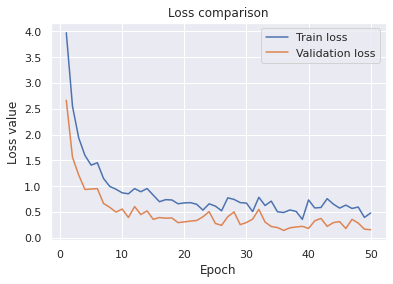

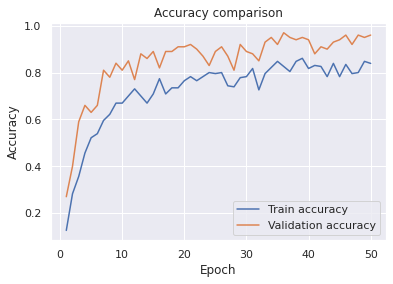

In [ ]:
# Fitting the model
epochs = 50
history = model.fit(X_resampled, oh_y_train, batch_size=15, epochs=epochs, verbose=True, validation_split=0.3);

print('\nTesting')
model.evaluate(X_test,  oh_y_test, verbose=2) 

# Plotting loss comparison between train and validation
plt.figure(figsize=(6, 4))
plt.title("Loss comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.plot(np.linspace(1, epochs, epochs), history.history["loss"], label="Train loss")
plt.plot(np.linspace(1, epochs, epochs), history.history["val_loss"], label="Validation loss")
plt.legend()
plt.show()

# Plotting accuracy comparison between train and validation
plt.figure(figsize=(6, 4))
plt.title("Accuracy comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(np.linspace(1, epochs, epochs), history.history["accuracy"], label="Train accuracy")
plt.plot(np.linspace(1, epochs, epochs), history.history["val_accuracy"], label="Validation accuracy")
plt.legend()
plt.show()

As can be seen above, the MLP gave verry similar results to the Random forest. 


It can be observed in the accuracy and loss evolution graphs that the network is not overfitting the data. One observation on the graph is that the validation scores are better than the training due to the dropout.

## Principal Component Analysis (PCA)

As said in the data analyses section, one possible solution to the small samples problem is to reduce the feature space of the problem. This can be done for example by feature selection or PCA. The PCA provides a set of new variables which are linear combinations of each original feature, but unlike the original features, the principal components are not correlated among each other.


To study if that in fact can improve the results, we decided to apply PCA to our data. Not only this method can possibly help solving the problem, but also working in a lower dimensional space is more computationally efficient.  

It can be seen in the graph bellow the explained variability given the number of PCs. We considered 8 to be a good number, as it can represent almost 99% of our data variability.


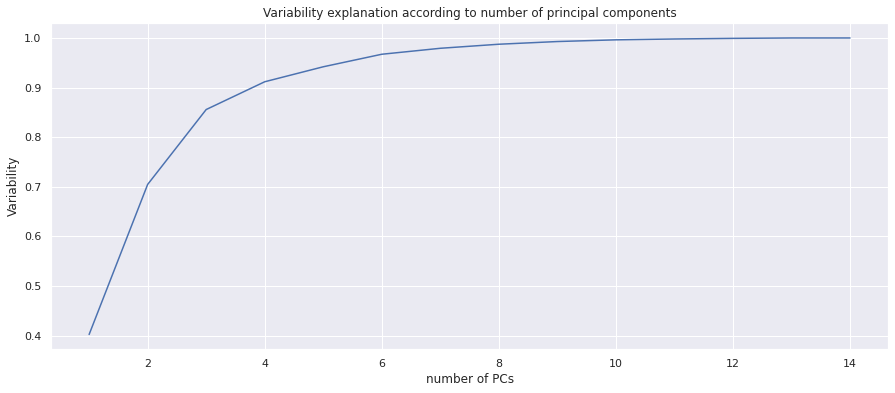

In [ ]:
# With the following visualization, we can see how many components are needed 
# to assure a great explainability of our data, looking for a value as low as possible
# (because we have very few samples), but with high explainability. 8 is a good compromise.
n_c = list(range(1,15))
evr = decomposition.PCA(n_components=14).fit(X_train).explained_variance_ratio_.cumsum()
plt.figure(figsize=(15, 6))
plt.title("Variability explanation according to number of principal components")
plt.xlabel("number of PCs")
plt.ylabel("Variability")
plt.plot(n_c, evr);

In [ ]:
print("Before PCA, number of features is:", X_train.shape[1])

# PCA reduction
pca = decomposition.PCA(n_components=8)
X_train_pca = pca.fit_transform(X_resampled)
X_test_pca = pca.transform(X_test)

print("After PCA, number of features is:", X_train_pca.shape[1])

Before PCA, number of feature is: 14
After PCA, number of feature is: 8


### Random Forest

I will first tackle the problem with a Random Fortest algorithm, with the help of grid search cross validation to tune the hyperparameters.

In [ ]:
params = {'criterion' : ['entropy', 'gini'],
          'n_estimators' : [2, 5, 10, 25, 50, 75, 100, 200]}   

rf = RandomForestClassifier(random_state=42)
rf_cv = GridSearchCV(rf, params)
rf_cv.fit(X_train_pca, y_resampled)
print("Best params:", rf_cv.best_params_)

Best params: {'criterion': 'entropy', 'n_estimators': 75}


In [ ]:
# Prediction
y_pred = rf_cv.predict(X_test_pca)

# Counting correct predictions
ncp = 0
for i in range(len(y_test)):
    if y_test[i] == y_pred[i]:
        ncp += 1

print("Number correct predictions RF: " + str(ncp) + "/" + str(len(y_test)))
print("Accuracy:", rf_cv.score(X_test_pca, y_test))

#print(pd.crosstab(y_test, y_pred, rownames=['Actual Species'], colnames=['Predicted Species']))

Number correct predictions RF: 69/85
Accuracy: 0.8117647058823529


The results with the RF are not bad, but they weren’t improved by applying PCA to the data.

Let's now with multiclass classification SVM, and also in this case let's use the grid search cross validation to look for the best kernel with the best hyperparameters.

### Support Vector machine (SVM)

In [ ]:
params = {'kernel' : ['linear', 'rbf', 'poly'],
          'decision_function_shape': ['ovo', 'ovr'],
          'C' : [0.01, 0.5, 1, 10, 50, 100],
          'gamma' : [.001, .05, 1, 2],
          'degree' : [2, 3, 4]}

svc = svm.SVC()
svc_cv = GridSearchCV(svc, params)
svc_cv.fit(X_train_pca, y_resampled)
print("Best params:", svc_cv.best_params_)
print("Accuracy SVM: ", svc_cv.score(X_test_pca, y_test))

Best params: {'C': 10, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 1, 'kernel': 'poly'}
Accuracy SVM:  0.7176470588235294


The results of SVM are worse than the Random Forest, which is expected, as bagging usually results in a model that has a better capacity to generalize the data, specially when the data is scarce.  <br>
To conclude our research, let's try now a MLP.

### Multilayer Perceptron (MLP)

Again, we will be using the same structure as before, and all observations made to the original dataset are valid now. 

Here is the structure of the NN: <br>
$$ (8) \rightarrow (50) \rightarrow (30) $$

In [ ]:
# First of all we need to apply the one-hot encoding to the labels,
# for te multiclass classification problem.
oh_y_train = tf.keras.utils.to_categorical(y_resampled) 
oh_y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
input_shape = X_train_pca.shape[1]
output_shape = 30

# Structure of NN definition
model = Sequential()
model.add(Dense(50, input_dim=input_shape, activation="sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(output_shape, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.1), metrics=['accuracy'])
model.summary()

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_192 (Dense)            (None, 50)                450       
_________________________________________________________________
dropout_96 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_193 (Dense)            (None, 30)                1530      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
12/12 [==============================] - 1s 22ms/step - loss: 4.4611 - accuracy: 0.0612 - val_loss: 2.8110 - val_accuracy: 0.3100
Epoch 2/50
12/12 [==============================] - 0s 6ms/step - loss: 2.7005 - accuracy: 0.2433 - val_loss: 1.7481 - val_accuracy: 0.4400
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 1.8567 - accuracy: 0.4049 - val_loss: 1.1362 - val_accuracy: 0.6700
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 1.2799 - accuracy: 0.5940 - val_loss: 0.7748 - val_accuracy: 0.8100
Epoch 5/50
12/12 [==============================] - 0s 6ms/step - loss: 1.0840 - accuracy: 0.6152 - val_loss: 0.6246 - val_accuracy: 0.8000
Epoch 6/50
12/12 [==============================] - 0s 6ms/step - loss: 0.9425 - accuracy: 0.6831 - val_loss: 0.5232 - val_accuracy: 0.8500
Epoch 7/50
12/12 [==============================] - 0s 6ms/step - loss: 0.7514 - accuracy: 0.7506 - val_loss: 0.4536 - val_accuracy: 0.8800
Epoch 8/50
12/12 [=

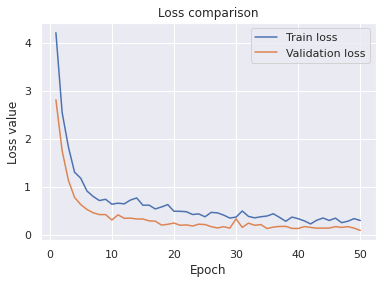

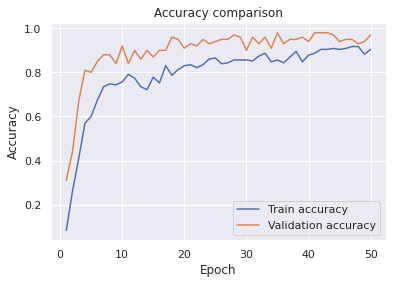

In [ ]:
# Fitting the model
epochs = 50
history = model.fit(X_train_pca, oh_y_train, batch_size=20, epochs=epochs, verbose=True, validation_split=0.3);

print('\nTesting')
model.evaluate(X_test_pca,  oh_y_test, verbose=2) 

# Plotting loss comparison between train and validation
plt.figure(figsize=(6, 4))
plt.title("Loss comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.plot(np.linspace(1, epochs, epochs), history.history["loss"], label="Train loss")
plt.plot(np.linspace(1, epochs, epochs), history.history["val_loss"], label="Validation loss")
plt.legend()
plt.show()

# Plotting accuracy comparison between train and validation
plt.figure(figsize=(6, 4))
plt.title("Accuracy comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(np.linspace(1, epochs, epochs), history.history["accuracy"], label="Train accuracy")
plt.plot(np.linspace(1, epochs, epochs), history.history["val_accuracy"], label="Validation accuracy")
plt.legend()
plt.show()

As can be seen above, PCA seems to really improve our results in this case, leading to about 5%  more accuracy in the results.

Number correct predictions MLP: 74/85
Accuracy:  0.8705882352941177


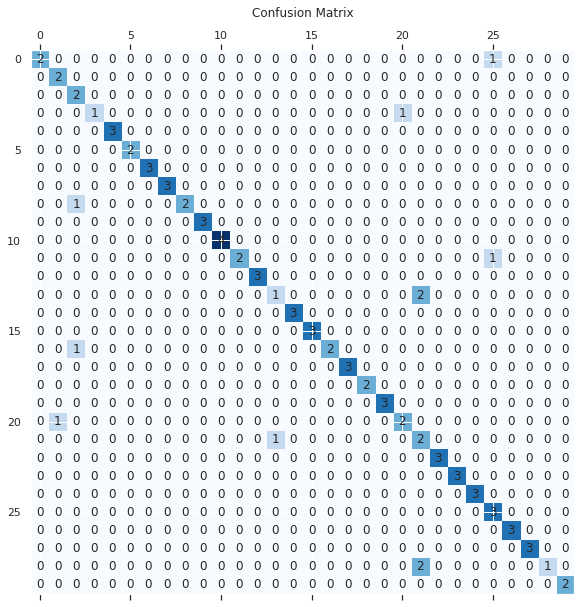

In [ ]:
y_pred = model.predict(X_test_pca); #prediction of the NN

# In the following code I transform the y_pred (arrays of real values),
# in arrays similar to the one-hot encoding, considering the maximum
# value of each array as the one that should be set at 1 and the other at 0
for i in range(len(y_pred)):
    m = 0
    mj = -1
    for j in range(len(y_pred[i])):
        if y_pred[i][j] > m:
            m = y_pred[i][j]
            mj = j
    for j in range(len(y_pred[i])):
        if j == mj:
            y_pred[i][j] = 1
        else:
            y_pred[i][j] = 0

# Counting correct predictions
ncp = 0
for i in range(len(y_test)):
    if np.array_equal(oh_y_test[i], y_pred[i]):
        ncp += 1

print("Number correct predictions MLP: " + str(ncp) + "/" + str(len(y_test)))
print("Accuracy: ", ncp/len(y_test))

confusion = confusion_matrix(y_test, np.argmax(y_pred, axis=-1))
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confusion.astype(int), cmap=plt.cm.Blues)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        c = confusion[j,i].astype(int)
        ax.text(i, j, str(c), va='center', ha='center')
plt.title("Confusion Matrix")
plt.show()

The MLP with PCA gave in the end the best results, predicting correctly over 87% of the testing data (separated at the beginning and never seen by the method). 


Considered the limitation of the datasets (very few samples for each class), we can consider it a good result. We can se in the confusion matrix plotted above that we’re indeed making verry few mistakes. One class that is worth mentioning is the 29th (originally 35), in which we make more mistakes than correct classification (2 vs 1 respectively). This may indicate that the few examples that our to our disposal of that class fails to well represent it. Also, a lot of our mistakes is related to predicting some other class as the 21 (originally 27).